In [ ]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import hvplot as hv
import hvplot.pandas
import sys, os
import matplotlib.pyplot as plt
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # parent of notebooks
if project_root not in sys.path:
    sys.path.append(project_root)
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV


from src.util.model import eval_model, prep_data
seed = 42

In [2]:
dff0 = pd.DataFrame()

data_fp = "../../data/training_data"
for fn in os.listdir(data_fp):
    df = pd.read_csv(os.path.join(data_fp, fn))
    print(f"{fn} {df.shape}")
    dff0 = pd.concat([dff0, df])
print(dff0.shape)

snow_2020-2025_p134_fxx1.csv (116216, 68)
snow_2020-2025_p198_fxx1.csv (145920, 68)
snow_2020-2025_p192_fxx1.csv (145920, 68)
snow_2020-2025_p193_fxx1.csv (145920, 68)
snow_2020-2025_p202_fxx1.csv (145920, 68)
snow_2020-2025_p153_fxx1.csv (145920, 68)
snow_2020-2025_p182_fxx1.csv (145920, 68)
snow_2020-2025_p183_fxx1.csv (145920, 68)
snow_2020-2025_p186_fxx1.csv (145920, 68)
snow_2020-2025_p121_fxx1.csv (145920, 68)
snow_2020-2025_p207_fxx1.csv (145920, 68)
snow_2020-2025_p206_fxx1.csv (145920, 68)
snow_2020-2025_p105_fxx1.csv (145920, 68)
snow_2020-2025_p200_fxx1.csv (145920, 68)
snow_2020-2025_p119_fxx1.csv (145920, 68)
snow_2020-2025_p151_fxx1.csv (145920, 68)
(2305016, 68)


In [3]:
danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])
danger_levels = danger_levels[danger_levels['lower'] > -1]
danger_levels = danger_levels.drop_duplicates()
print(danger_levels.shape)
print(danger_levels.head())

(4033, 7)
        date     id  danger_rating forecast_zone_id  lower  upper  middle
0 2020-10-19  90469              0         flathead      0      0       0
1 2020-10-20  90469              0         flathead      0      0       0
2 2020-10-21  90469              0         flathead      0      0       0
3 2020-10-22  90469              0         flathead      0      0       0
4 2020-10-23  90469              0         flathead      0      0       0


In [4]:
X, y = prep_data(
    dff0, 
    danger_levels, 
    replace_missing=True, 
    change_danger=True,
    exclude_cols=['date','id','slope_azi', 'danger_level','altitude','slope_angle']) 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

In [ ]:
rf = RandomForestClassifier(random_state=seed,n_jobs=-1)

param_dict = {
    "n_estimators":[100,500,1000],
    "max_depth":[10,25,50],
    "min_samples_split":[2,10,20],
    "min_samples_leaf":[1,4,10],
    "max_features":["sqrt","log2",0.5],
    "class_weight":["balanced"],   
}

cfv = HalvingGridSearchCV(estimator=rf, 
                          param_grid=param_dict,
                          scoring='balanced_accuracy',
                          return_train_score=True,
                          factor=4,
                          cv=3,
                          n_jobs=-1,verbose=1).fit(X_train,y_train)

In [18]:
print(cfv.best_params_)

{'class_weight': 'balanced', 'max_depth': 50, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 1000}


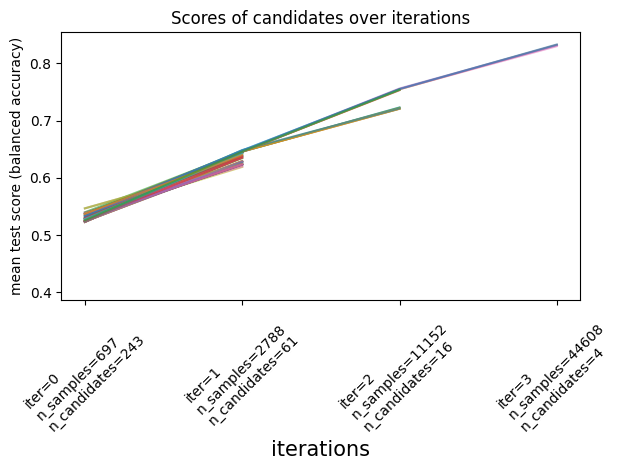

In [23]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_iterations.html#sphx-glr-auto-examples-model-selection-plot-successive-halving-iterations-py
results = pd.DataFrame(cfv.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={cfv.n_resources_[i]}\nn_candidates={cfv.n_candidates_[i]}"
    for i in range(cfv.n_iterations_)
]

ax.set_xticks(range(cfv.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score (balanced accuracy)", fontsize=10)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()


In [20]:
results.iloc[cfv.best_index_]

iter                                                                       3
n_resources                                                            44608
mean_fit_time                                                     1078.58301
std_fit_time                                                        10.09867
mean_score_time                                                     4.099939
std_score_time                                                      0.044521
param_class_weight                                                  balanced
param_max_depth                                                           50
param_max_features                                                       0.5
param_min_samples_leaf                                                     4
param_min_samples_split                                                   20
param_n_estimators                                                      1000
params                     {'class_weight': 'balanced', 'max_depth': 50, ...